# Robust Hedging – Training & Evaluation

This notebook lets you train the minimax CVaR PPO hedger, inspect the resulting metrics, and produce the plots you need for Chapter 5.

## 0. Environment Notes

- Run this notebook from the project root (`/Users/arankhaira/Documents/Dissertation/chapters`).
- Make sure PyTorch is installed with either CUDA, MPS, or CPU support.
- To reproduce the CLI behaviour, we seed all RNGs via `robust_hedge.utils.seed_all`.

In [29]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from robust_hedge.config import HedgeConfig
from robust_hedge.training import RobustCVaRPPO
from robust_hedge.evaluation import evaluate_policy_suite
from robust_hedge.utils import seed_all


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Configuration

You can tweak any of the hyperparameters here before running training. The defaults mirror the CLI flags we have been using.

In [30]:
# For quick experimentation you can drop steps to 126 and later revert to 252 for final runs
cfg = HedgeConfig(
    steps=252,
    eps=0.02,
    alpha=0.95,
    rollout_episodes=64,
    evaluation_episodes=256,
    save_checkpoints=True, checkpoint_dir="checkpoints_run2",
    seed=1337,
)

cfg


HedgeConfig(T=1.0, steps=252, mu=0.0, r=0.0, sigma_L=0.2, sigma_H=0.5, S0=100.0, K=100.0, seed=1337, known_regime=False, eps=0.02, alpha=0.95, P_bar=tensor([[0.9800, 0.0200],
        [0.0400, 0.9600]]), device=device(type='mps'), dtype=torch.float32, actor_hidden=128, critic_hidden=128, actor_lr=0.0003, critic_lr=0.0003, actor_lr_final=0.0001, critic_lr_final=0.0001, zeta_lr=0.005, zeta_lr_min=0.0001, zeta_lr_decay=0.9, coverage_target=0.03, clip_epsilon=0.2, entropy_coef=0.001, entropy_coef_final=0.0003, value_coef=0.5, max_grad_norm=1.0, target_kl=0.03, rollout_episodes=64, evaluation_episodes=256, rollout_schedule=((2, 16), (4, 32)), evaluation_schedule=((2, 64), (4, 128)), minibatch_size=32, ppo_epochs=2, log_std_init=-0.5, min_log_std=-2.0, max_log_std=1.0, state_dim=7, action_dim=1, max_hedge=5.0, save_checkpoints=True, checkpoint_dir=PosixPath('checkpoints_run2'), checkpoint_interval=2, use_antithetic=True)

## 2. Training

Set `DO_TRAINING` to `True` to launch training from the notebook. The `train()` function returns the list of `TrainingStats` objects and also writes `training_stats.json` to disk.

In [31]:
DO_TRAINING = True  # flip to True when you want to run a training session
TRAINING_OUTPUT = Path("training_stats_run2.json")
BASE_OUTPUT = Path("training_stats.json")
BACKUP_OUTPUT = Path("training_stats_run1.json")

stats = None

seed_all(cfg.seed)
# Episode ramp schedule is governed by cfg.rollout_schedule / cfg.evaluation_schedule
trainer = RobustCVaRPPO(cfg)

# Optional: load previous weights before training
if Path("policy.pt").exists() and Path("value.pt").exists():
    policy_state = torch.load("policy.pt", map_location=cfg.device)
    value_state = torch.load("value.pt", map_location=cfg.device)
    trainer.policy.actor.load_state_dict(policy_state)
    trainer.policy.critic.load_state_dict(value_state)
    if Path("actor_opt.pt").exists() and Path("critic_opt.pt").exists():
        trainer.actor_opt.load_state_dict(torch.load("actor_opt.pt", map_location=cfg.device))
        trainer.critic_opt.load_state_dict(torch.load("critic_opt.pt", map_location=cfg.device))

if DO_TRAINING:
    if BASE_OUTPUT.exists() and not BACKUP_OUTPUT.exists():
        BACKUP_OUTPUT.write_text(BASE_OUTPUT.read_text())
    stats = trainer.train(iterations=5)
    payload = [
        {
            "iteration": s.iteration,
            "zeta": s.zeta,
            "loss_mean": s.loss_mean,
            "loss_cvar": s.loss_cvar,
            "loss_var": s.loss_var,
            "worst_corner_index": s.worst_corner_index,
            "actor_loss": s.actor_loss,
            "critic_loss": s.critic_loss,
            "approx_kl": s.approx_kl,
            "coverage_error": s.coverage_error,
            "tail_probability": s.tail_probability,
            "env_steps": s.env_steps,
            "actor_lr": s.actor_lr,
            "critic_lr": s.critic_lr,
            "entropy_coef": s.entropy_coef,
            "zeta_lr": s.zeta_lr,
            "eval_metrics": s.eval_metrics,
        }
        for s in stats
    ]
    TRAINING_OUTPUT.write_text(json.dumps(payload, indent=2))
    BASE_OUTPUT.write_text(json.dumps(payload, indent=2))
    print(f"Saved {TRAINING_OUTPUT}")

    # Save trained weights for future reuse
    POLICY_PATH = Path("policy.pt")
    VALUE_PATH = Path("value.pt")
    torch.save(trainer.policy.actor.state_dict(), POLICY_PATH)
    torch.save(trainer.policy.critic.state_dict(), VALUE_PATH)
    torch.save(trainer.actor_opt.state_dict(), Path("actor_opt.pt"))
    torch.save(trainer.critic_opt.state_dict(), Path("critic_opt.pt"))
    print("Saved optimizer states to actor_opt.pt / critic_opt.pt")
    print(f"Saved actor weights to {POLICY_PATH}")
    print(f"Saved critic weights to {VALUE_PATH}")
else:
    print("Training skipped. Using current (untrained) policy; load weights if needed.")


/var/folders/p4/z0l9gthd67lgznhtqfbh43bc0000gn/T/ipykernel_19472/160233527.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_state = torch.load("policy.pt", map_lo

Starting training for 5 iterations (rollout base=64, eval base=256)
Iteration 1/5: evaluating rectangle corners (64 episodes per corner)...
    Corner 1/4 | episode 64/64 | mean loss 4744.7895
    Corner 2/4 | episode 64/64 | mean loss 3776.1107
    Corner 3/4 | episode 64/64 | mean loss 2076.9698
    Corner 4/4 | episode 64/64 | mean loss 2075.5650
Iteration 1/5: collecting 16 rollouts...
  Rollout 16/16 | mean loss 4349.8751
Iteration 1/5: full evaluation suite (64 episodes per scenario)...
  P_bar | episode 64/64 | mean loss 3515.1465
    Corner 1/4 | episode 64/64 | mean loss 5064.3252
    Corner 2/4 | episode 64/64 | mean loss 3743.6963
    Corner 3/4 | episode 64/64 | mean loss 2234.2094
    Corner 4/4 | episode 64/64 | mean loss 2142.8279
  Worst corner evaluation complete
    Corner 1/4 | episode 64/64 | mean loss 5403.8692
    Corner 2/4 | episode 64/64 | mean loss 3322.4579
    Corner 3/4 | episode 64/64 | mean loss 2116.2951
    Corner 4/4 | episode 64/64 | mean loss 2098.32

## 3. Load Training Stats

Load existing statistics so you can analyse or plot without re-running training.

In [32]:
stats_path_candidates = [Path("training_stats_run2.json"), Path("training_stats.json"), Path("training_stats_run1.json")]
for candidate in stats_path_candidates:
    if candidate.exists():
        stats_path = candidate
        break
else:
    raise FileNotFoundError("No training statistics file found. Run training first.")

with stats_path.open() as f:
    raw_stats = json.load(f)

stats_df = pd.DataFrame(raw_stats)
stats_df


,iteration,zeta,loss_mean,loss_cvar,loss_var,worst_corner_index,actor_loss,critic_loss,approx_kl,coverage_error,tail_probability,env_steps,actor_lr,critic_lr,entropy_coef,zeta_lr,eval_metrics
0,1,653.907532,4744.789062,10571.293945,8784.995117,0,0.002901,36.676003,0.002655,0.950000,1.000000,8064,0.00030,0.00030,0.001000,0.004500,"{'P_bar': {'agent': {'mean': 3515.146484375, '..."
1,2,653.987427,5292.947266,14831.724609,12676.062500,0,-0.028434,47.182617,0.012901,0.887500,0.937500,8064,0.00025,0.00025,0.000825,0.004050,"{'P_bar': {'agent': {'mean': 3516.45703125, 'v..."
2,3,872.704529,4752.244629,10772.359375,9265.540039,0,-0.017454,36.789513,0.002775,0.950000,1.000000,16128,0.00020,0.00020,0.000650,0.003645,"{'P_bar': {'agent': {'mean': 3383.765625, 'var..."
3,4,872.764648,4900.896484,11495.245117,9954.409180,0,-0.124004,46.009346,0.008549,0.825000,0.875000,16128,0.00015,0.00015,0.000475,0.003281,"{'P_bar': {'agent': {'mean': 3382.11181640625,..."
4,5,872.819824,4819.473633,11705.722656,9913.249023,0,-0.049958,48.807247,0.002240,0.840625,0.890625,32256,0.00010,0.00010,0.000300,0.002952,"{'P_bar': {'agent': {'mean': 3635.6240234375, ..."


## 4. Plot PPO Diagnostics

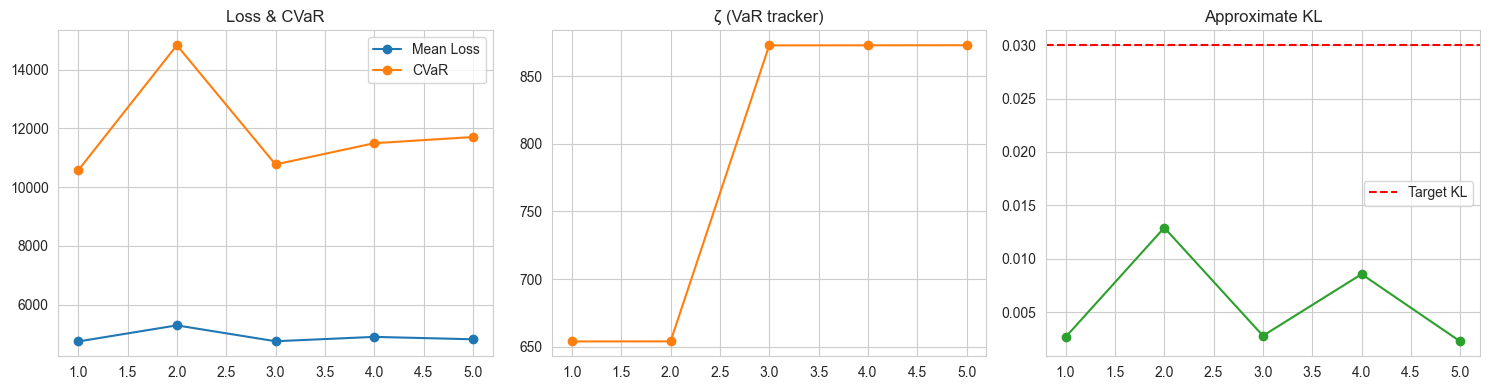

In [33]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(stats_df["iteration"], stats_df["loss_mean"], marker="o", label="Mean Loss")
axes[0].plot(stats_df["iteration"], stats_df["loss_cvar"], marker="o", label="CVaR")
axes[0].set_title("Loss & CVaR")
axes[0].legend()

axes[1].plot(stats_df["iteration"], stats_df["zeta"], marker="o", color="tab:orange")
axes[1].set_title("ζ (VaR tracker)")

axes[2].plot(stats_df["iteration"], stats_df["approx_kl"], marker="o", color="tab:green")
axes[2].axhline(cfg.target_kl, color="red", linestyle="--", label="Target KL")
axes[2].set_title("Approximate KL")
axes[2].legend()

plt.tight_layout()
plt.show()


## 5. Evaluate Policy Across Scenarios

This cell rebuilds the evaluation table from the latest policy so you can cross-check the JSON results or try different ε multipliers.

In [34]:
# Evaluate the current policy (trained if you ran the previous cell)
if 'trainer' not in globals() or trainer is None:
    raise RuntimeError("No trainer instance available. Run the training cell first or load weights.")

# Optionally load saved weights here, e.g.
# trainer.policy.actor.load_state_dict(torch.load('policy.pt'))
# trainer.policy.critic.load_state_dict(torch.load('value.pt'))
# trainer.actor_opt.load_state_dict(torch.load('actor_opt.pt'))
# trainer.critic_opt.load_state_dict(torch.load('critic_opt.pt'))

eval_results = evaluate_policy_suite(
    cfg,
    trainer.policy.act,
    episodes=1024,
    alpha=cfg.alpha,
    eps_multiplier=1.5,
    progress=True,
)

eval_results

  P_bar | episode 1024/1024 | mean loss 3714.4154
    Corner 1/4 | episode 1024/1024 | mean loss 4985.0099
    Corner 2/4 | episode 1024/1024 | mean loss 3837.6149
    Corner 3/4 | episode 1024/1024 | mean loss 2158.9162
    Corner 4/4 | episode 1024/1024 | mean loss 2123.8732
  Worst corner evaluation complete
    Corner 1/4 | episode 1024/1024 | mean loss 5497.0161
    Corner 2/4 | episode 1024/1024 | mean loss 4014.6221
    Corner 3/4 | episode 1024/1024 | mean loss 2119.7367
    Corner 4/4 | episode 1024/1024 | mean loss 2156.9901
  Stress corner evaluation complete


{'P_bar': {'agent': {'mean': 3714.41552734375,
   'var': 7295.33203125,
   'cvar': 9534.5771484375},
  'bs_delta': {'mean': 2939.2373046875,
   'var': 8424.6953125,
   'cvar': 11672.6943359375},
  'no_hedge': {'mean': 3146.22265625,
   'var': 9219.3291015625,
   'cvar': 12748.7900390625}},
 'worst_corner': {'agent': {'mean': 4985.009765625,
   'var': 9818.703125,
   'cvar': 12742.1103515625},
  'bs_delta': {'mean': 4127.2451171875,
   'var': 12702.0615234375,
   'cvar': 17529.08203125},
  'no_hedge': {'mean': 4040.107421875,
   'var': 12865.4541015625,
   'cvar': 18112.087890625}},
 'stress_corner': {'agent': {'mean': 5497.01611328125,
   'var': 10473.1220703125,
   'cvar': 13601.158203125},
  'bs_delta': {'mean': 4760.2685546875,
   'var': 14271.458984375,
   'cvar': 18894.177734375},
  'no_hedge': {'mean': 4464.5703125,
   'var': 14116.71484375,
   'cvar': 19757.091796875}}}

## 6. Scenario Comparison Plot

Create a bar chart comparing CVaR across the agent and baselines for each scenario.

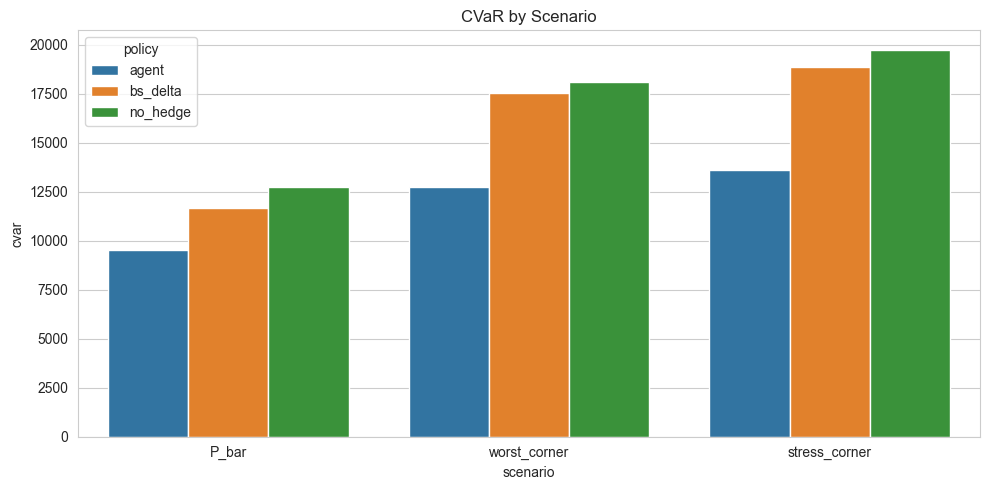

In [35]:
records = []
for scenario, metrics in eval_results.items():
    for policy_name, vals in metrics.items():
        record = {"scenario": scenario, "policy": policy_name, **vals}
        records.append(record)

df_eval = pd.DataFrame(records)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_eval, x="scenario", y="cvar", hue="policy")
ax.set_title("CVaR by Scenario")
plt.tight_layout()
plt.show()


## 7. Notes & Next Steps

- Swap `DO_TRAINING` to `True` to run new experiments from the notebook.
- If you save policy state dicts, add a cell to load them before running the evaluation.
- Adjust the plotting cells to match the specific figures you need for the dissertation.


In [49]:
from copy import deepcopy

def build_eval_history(stats_df):
    records = []
    for _, row in stats_df.iterrows():
        for scenario, metrics in row.eval_metrics.items():
            for policy, values in metrics.items():
                rec = {
                    "iteration": row.iteration,
                    "scenario": scenario,
                    "policy": policy,
                    "mean": values["mean"],
                    "var": values["var"],
                    "cvar": values["cvar"],
                }
                records.append(rec)
    return pd.DataFrame(records)

eval_hist_df = build_eval_history(stats_df)
eval_hist_df.head()


,iteration,scenario,policy,mean,var,cvar
0,1,P_bar,agent,3515.146484,6623.924316,8784.269531
1,1,P_bar,bs_delta,3127.659180,9378.531250,10955.624023
2,1,P_bar,no_hedge,2941.183838,9854.100586,11973.953125
3,1,worst_corner,agent,5064.325195,9676.358398,11137.616211
4,1,worst_corner,bs_delta,3074.177246,8523.598633,11966.067383


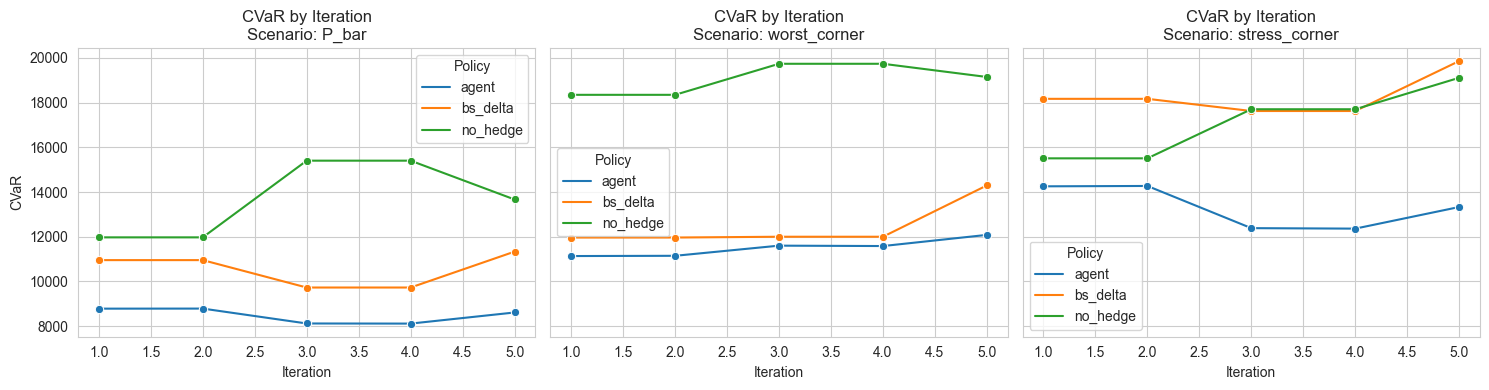

In [50]:
sns.set_style("whitegrid")
scenarios = eval_hist_df["scenario"].unique()

fig, axes = plt.subplots(1, len(scenarios), figsize=(5 * len(scenarios), 4), sharey=True)
if len(scenarios) == 1:
    axes = [axes]

for ax, scen in zip(axes, scenarios):
    data = eval_hist_df[eval_hist_df["scenario"] == scen]
    sns.lineplot(data=data, x="iteration", y="cvar", hue="policy", marker="o", ax=ax)
    ax.set_title(f"CVaR by Iteration\nScenario: {scen}")
    ax.set_ylabel("CVaR")
    ax.set_xlabel("Iteration")
    ax.legend(title="Policy")

plt.tight_layout()
plt.show()


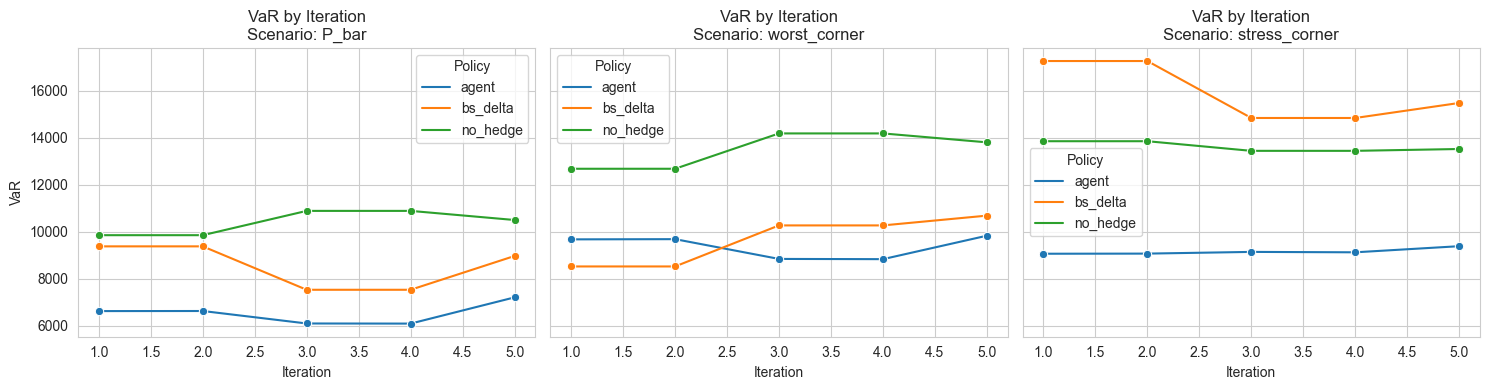

In [51]:
fig, axes = plt.subplots(1, len(scenarios), figsize=(5 * len(scenarios), 4), sharey=True)
if len(scenarios) == 1:
    axes = [axes]

for ax, scen in zip(axes, scenarios):
    data = eval_hist_df[eval_hist_df["scenario"] == scen]
    sns.lineplot(data=data, x="iteration", y="var", hue="policy", marker="o", ax=ax)
    ax.set_title(f"VaR by Iteration\nScenario: {scen}")
    ax.set_ylabel("VaR")
    ax.set_xlabel("Iteration")
    ax.legend(title="Policy")

plt.tight_layout()
plt.show()


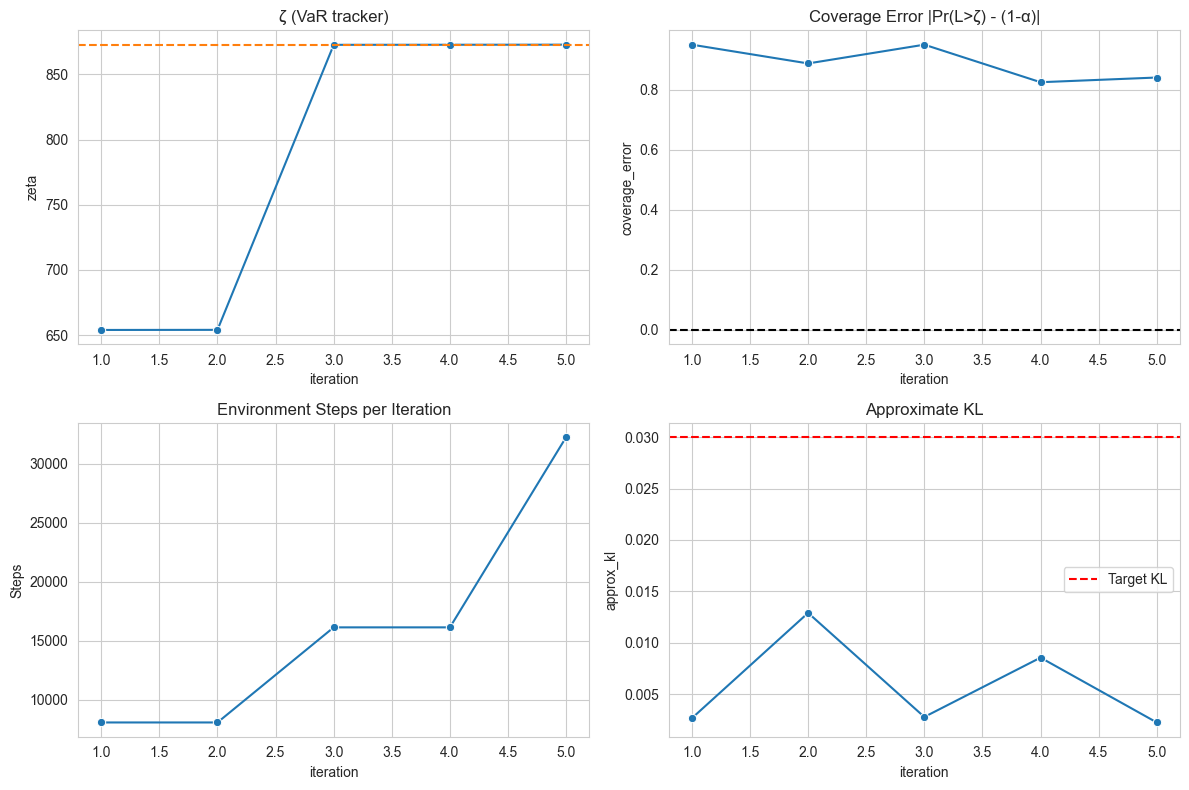

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

sns.lineplot(data=stats_df, x="iteration", y="zeta", marker="o", ax=axes[0])
axes[0].set_title("ζ (VaR tracker)")
axes[0].axhline(stats_df["zeta"].iloc[-1], color="tab:orange", linestyle="--")

sns.lineplot(data=stats_df, x="iteration", y="coverage_error", marker="o", ax=axes[1])
axes[1].set_title("Coverage Error |Pr(L>ζ) - (1-α)|")
axes[1].axhline(0.0, color="black", linestyle="--")

sns.lineplot(data=stats_df, x="iteration", y="env_steps", marker="o", ax=axes[2])
axes[2].set_title("Environment Steps per Iteration")
axes[2].set_ylabel("Steps")

sns.lineplot(data=stats_df, x="iteration", y="approx_kl", marker="o", ax=axes[3])
axes[3].set_title("Approximate KL")
axes[3].axhline(cfg.target_kl, color="red", linestyle="--", label="Target KL")
axes[3].legend()

plt.tight_layout()
plt.show()


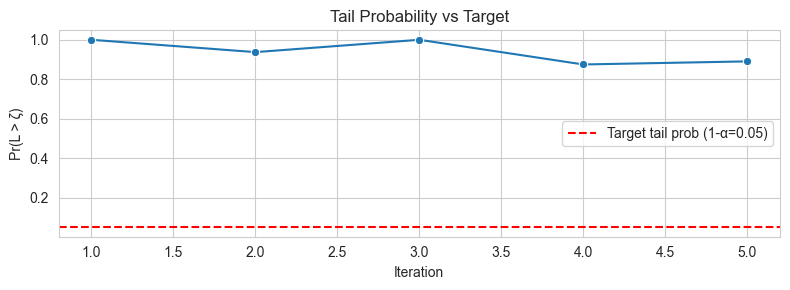

In [53]:
plt.figure(figsize=(8, 3))
sns.lineplot(data=stats_df, x="iteration", y="tail_probability", marker="o")
plt.axhline(1 - cfg.alpha, color="red", linestyle="--", label=f"Target tail prob (1-α={1-cfg.alpha:.2f})")
plt.title("Tail Probability vs Target")
plt.ylabel("Pr(L > ζ)")
plt.xlabel("Iteration")
plt.legend()
plt.tight_layout()
plt.show()

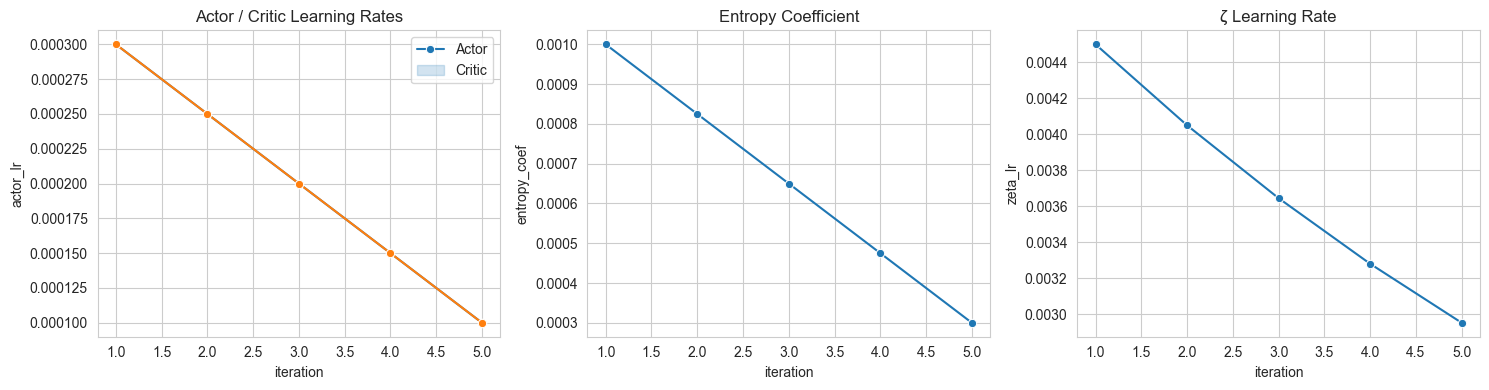

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.lineplot(data=stats_df, x="iteration", y="actor_lr", marker="o", ax=axes[0])
sns.lineplot(data=stats_df, x="iteration", y="critic_lr", marker="o", ax=axes[0])
axes[0].set_title("Actor / Critic Learning Rates")
axes[0].legend(["Actor", "Critic"])

sns.lineplot(data=stats_df, x="iteration", y="entropy_coef", marker="o", ax=axes[1])
axes[1].set_title("Entropy Coefficient")

sns.lineplot(data=stats_df, x="iteration", y="zeta_lr", marker="o", ax=axes[2])
axes[2].set_title("ζ Learning Rate")

plt.tight_layout()
plt.show()


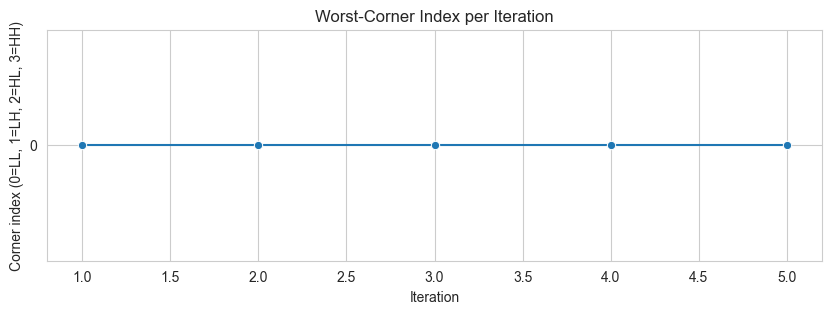

In [42]:
plt.figure(figsize=(10, 3))
sns.lineplot(data=stats_df, x="iteration", y="worst_corner_index", marker="o")
plt.title("Worst-Corner Index per Iteration")
plt.yticks(range(int(stats_df["worst_corner_index"].max()) + 1))
plt.xlabel("Iteration")
plt.ylabel("Corner index (0=LL, 1=LH, 2=HL, 3=HH)")
plt.show()


In [43]:
records = []
for scenario, metrics in eval_results.items():
    for policy_name, values in metrics.items():
        entry = {"scenario": scenario, "policy": policy_name}
        entry.update(values)
        records.append(entry)

final_eval_df = pd.DataFrame(records)
final_eval_df


,scenario,policy,mean,var,cvar
0,P_bar,agent,3714.415527,7295.332031,9534.577148
1,P_bar,bs_delta,2939.237305,8424.695312,11672.694336
2,P_bar,no_hedge,3146.222656,9219.329102,12748.790039
3,worst_corner,agent,4985.009766,9818.703125,12742.110352
4,worst_corner,bs_delta,4127.245117,12702.061523,17529.082031
5,worst_corner,no_hedge,4040.107422,12865.454102,18112.087891
6,stress_corner,agent,5497.016113,10473.122070,13601.158203
7,stress_corner,bs_delta,4760.268555,14271.458984,18894.177734
8,stress_corner,no_hedge,4464.570312,14116.714844,19757.091797


In [44]:
def compute_improvement(df):
    pivot = df.pivot(index="scenario", columns="policy", values="cvar")
    agent = pivot["agent"]
    summary = pd.DataFrame({
        "CB Agent CVaR": agent,
        "BS-delta CVaR": pivot.get("bs_delta"),
        "No-hedge CVaR": pivot.get("no_hedge"),
    })
    summary["Δ vs BS-delta (%)"] = (summary["CB Agent CVaR"] / summary["BS-delta CVaR"] - 1) * 100
    summary["Δ vs No-hedge (%)"] = (summary["CB Agent CVaR"] / summary["No-hedge CVaR"] - 1) * 100
    return summary

summary_table = compute_improvement(final_eval_df)
summary_table

,CB Agent CVaR,BS-delta CVaR,No-hedge CVaR,Δ vs BS-delta (%),Δ vs No-hedge (%)
scenario,,,,,
P_bar,9534.577148,11672.694336,12748.790039,-18.317255,-25.211905
stress_corner,13601.158203,18894.177734,19757.091797,-28.014024,-31.158096
worst_corner,12742.110352,17529.082031,18112.087891,-27.308741,-29.648584


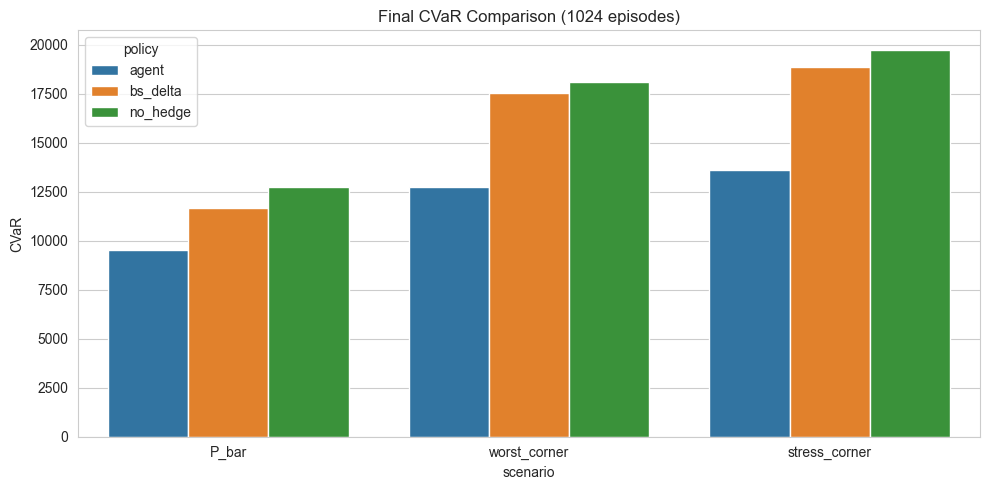

In [45]:
plt.figure(figsize=(10, 5))
sns.barplot(data=final_eval_df, x="scenario", y="cvar", hue="policy")
plt.title("Final CVaR Comparison (1024 episodes)")
plt.ylabel("CVaR")
plt.tight_layout()
plt.show()


In [46]:
final_eval_df.sort_values(by=["scenario", "policy"]).to_csv("final_evaluation_summary.csv", index=False)


In [47]:
import numpy as np

def bootstrap_cvar(losses, alpha=cfg.alpha, n_boot=1000):
    arr = losses.detach().cpu().numpy()
    n = len(arr)
    estimates = []
    for _ in range(n_boot):
        sample = np.random.choice(arr, size=n, replace=True)
        var = np.quantile(sample, alpha)
        estimates.append(sample[sample >= var].mean())
    return np.mean(estimates), np.percentile(estimates, [2.5, 97.5])

# Example usage:
mean_cvar, ci = bootstrap_cvar(torch.tensor(eval_results["worst_corner"]["agent"]["samples"]))
print("Bootstrapped CVaR:", mean_cvar, "95% CI:", ci)


KeyError: 'samples'